# Importing and preprocessing of data

In [1]:
from google.colab import drive

drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
TXTS_PATH = '/content/drive/My Drive/Becode/Kpmg/selection_fr'

In [3]:
import os

In [4]:
import pandas as pd
pd.set_option('display.max_colwidth', 255)

In [5]:
KPMG_PATH = '/content/drive/My Drive/Becode/Kpmg'
RESPONSES_PATH = '/content/drive/My Drive/Becode/Kpmg/responses_2018_now.json'

In [6]:
txt_filenames = [f for f in os.listdir(TXTS_PATH) if f.endswith(".txt")]

In [7]:
#reading json file to retrieve tags
responses = pd.read_json(RESPONSES_PATH)

In [8]:
#filtering only relevant columns
columns = ['jcId', 'jcFr', 'titleFr', 'themesFr', 'scopeFr', 'noScopeFr', 'documentLink']
responses2 = responses.copy(deep=True).loc[:,columns]
#getting txt_name from original pdf name
responses2["txt_name"] = responses2["documentLink"]
responses2["txt_name"] = responses2["txt_name"].str.replace("/","-")
responses2["txt_name"] = responses2["txt_name"].str.replace(".pdf","_FR.txt")
#filtering json only for selected files and columns
columns += ['txt_name']
responses2 = responses2.loc[responses2.txt_name.isin(txt_filenames), columns]
responses2.head(2)

,jcId,jcFr,titleFr,themesFr,scopeFr,noScopeFr,documentLink,txt_name
34,1110000,"COMMISSION PARITAIRE DES CONSTRUCTIONS METALLIQUE, MECANIQUE ET ELECTRIQUE","modification du régime de pension sectoriel social, du règlement de pension et du règlement de solidarité",[PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES],None,"[les employeurs et ouvriers des entreprises exemptées du paiement d'une cotisation pour le régime de pension sectorielsur la base d'un accord d'entreprise relatif à l'instauration ou à l'élargissement d'un régime de pension complémentaire, employeurs ...",111/111-2018-013525.pdf,111-111-2018-013525_FR.txt
35,1110000,"COMMISSION PARITAIRE DES CONSTRUCTIONS METALLIQUE, MECANIQUE ET ELECTRIQUE",allocation spéciale compensatoire,[PRIME SYNDICALE],None,None,111/111-2018-012196.pdf,111-111-2018-012196_FR.txt


In [9]:
#generating all possible FR themes
themes_fr = []
for r in  responses2.themesFr:
    if r is not None:
        for t in r:
            if t not in themes_fr:
                themes_fr += [t]
len(themes_fr)


54

In [10]:
#code to retrieve the entire body
#%%
for filename in responses2.txt_name.to_list():
    # filename = responses2.txt_name.to_list()[10] #test
    file_path = os.path.join(TXTS_PATH, filename)
    with open(file_path, 'r', encoding="utf8") as f:
        #to retrieve entire body not necessary
        responses2.loc[responses2.txt_name == filename, "doc_bodies"] = f.read()
        f.close()

In [11]:
t = themes_fr[0]
mask = responses2.dropna(axis=0, subset=['themesFr']).themesFr.map(lambda x: t in x)

In [12]:
len(responses2)

578

In [13]:
 #len(responses2.dropna(axis=0, subset=['themesFr'])[map])

# Regex extraction

In [14]:
"""This script regex-extracts information from the document bodies to new DataFrame columns"""
#redundant libraries to be checked
import datetime
from pickle import load
import re

import numpy as np
import pandas as pd

In [142]:
def split_func(text):
  texts_lst = []
  sents = text.split("\n\n")
  for sent in sents:
    texts_lst.append(sent)
  return texts_lst

In [150]:
def extract_pattern(lst:List, pattern:str):
  output_lst = []
  for item in lst: 
    if re.search(pattern, item, flags=re.IGNORECASE):
      output_lst.append(item)
    else:
      pass
  return '\n'.join(output_lst)

In [152]:
def extract_scope(lst):
  output_lst = []
  for item in lst: 
    #pattern1 = r".*\b(convention collective de travail s'applique | Champ d'application)\b.*"
    #pattern2 = r".*\b(La présente convention collective de travail\s*\S* [a-z]'appli\w*)\b.*"
    #pattern3 = r".*\b(convention collective de travail|CCT)\s*\S*[a-z]('appli\w*)\b.*"
    #pattern4 = r".*\b(convention collective de travail|CCT)\s*\S*.*('?appli\w*)\b.*"
    #pattern = r".*\b(convention collective de.*travail|CCT).*('*appli\w*)\b.*"
    pattern = r".*((convention collective de )(travail|CCT))*.*"
    if re.search(pattern, item, flags=re.IGNORECASE):
      output_lst.append(item)
    else:
      pass
  return '\n'.join(output_lst)

In [153]:
def extract_deposit(lst):
  output_lst = []
  for item in lst: 
    pattern =r".*(épôt).*"
    if re.search(pattern, item, flags=re.IGNORECASE):
      output_lst.append(item)
    else:
      pass
  return '\n'.join(output_lst)

In [154]:
def add_tags(df, body_column):
  df['texts_lst'] = df[body_column].apply(split_func)
  #pattern1 = r".*\b(convention collective de travail s'applique | Champ d'application)\b.*
  #pattern2 = r".*\b(La présente convention collective de travail\s*\S* [a-z]'appli\w*)\b.*"
  #pattern3 = r".*\b(convention collective de travail|CCT)\s*\S*[a-z]('appli\w*)\b.*"
  #pattern4 = r".*\b(convention collective de travail|CCT)\s*\S*.*('?appli\w*)\b.*"
  #pattern = r".*\b(convention collective de.*travail|CCT).*('*appli\w*)\b.*"
  df['scopeFr'] = df['texts_lst'].apply(extract_scope)
  df['depotFr'] = df['texts_lst'].apply(extract_deposit)
  df.drop(columns=['texts_lst'], inplace = True)
  return df

In [177]:
df = responses2.head(5)
df['texts_lst'] = df["doc_bodies"].apply(split_func)
df['texts_lst']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


34    [Neerlegging-Dépôt: 18/12/2018, Regist.-Enregistr.: 07/01/2019, N°: 149887/C0/111 , COMMISSION PARITAIRE DES CONSTRUCTIONS |, METALLIQUE, MECANIQUE ET ELECTRIQUE (PC |, Mt) , | , | , Ì       , CONVENTION COLLECTIVE DE TRAVAIL DU 17, DECEMBRE 2018 MODI...
35    [COMMISSION PARITAIRE 111 DES CONSTRUCTIONS, MÉTALLIQUE, MÉCANIQUE ET ÉLECTRIQUE , Convention collective de travail du 15 octobre 2018 , ALLOCATION SPECIALE COMPENSATOIRE , Chapitre ler. - Champ d'application , Article 1er. - La présente convention co...
36    [Neerlegging-Dépôt: 17/10/2018, Regist.-Enregistr.: 05/11/2018, N°: 148625/CO/111 , COMMISION PARITAIRE DE LA CONSTRUCTION, METALLIQUE, MECANIQUE ET ELECTRIQUE SECTION MONTAGE (CP 111.3) , Convention collective de travail du 15 octobre 2018 , MODIFICA...
37    [Neerlegging-Dépôt: 05/09/2018, Regist.-Enregistr.: 17/10/2018, N°: 148350/C0/111 , Commission paritaire des constructions métallique, mécanique et électrique , Convention collective de travail du 3 septembre 20

In [159]:
df['depotFr'] = df['texts_lst'].apply(extract_deposit)
df['depotFr']
#df = add_tags(df, "doc_bodies")
#df.loc[:,['txt_name','depotFr']]


34                                                                                                                                                                                                                                       Neerlegging-Dépôt: 18/12/2018
35                                                                                                                                                                                                                                                                    
36                                                                                                                                                                                                                                       Neerlegging-Dépôt: 17/10/2018
37                                                                                                                                                                                                                 

In [97]:
responses2.head(5)

,jcId,jcFr,titleFr,themesFr,scopeFr,noScopeFr,documentLink,txt_name,doc_bodies,bodies_cleaned
34,1110000,"COMMISSION PARITAIRE DES CONSTRUCTIONS METALLIQUE, MECANIQUE ET ELECTRIQUE","modification du régime de pension sectoriel social, du règlement de pension et du règlement de solidarité",[PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES],None,"[les employeurs et ouvriers des entreprises exemptées du paiement d'une cotisation pour le régime de pension sectorielsur la base d'un accord d'entreprise relatif à l'instauration ou à l'élargissement d'un régime de pension complémentaire, employeurs ...",111/111-2018-013525.pdf,111-111-2018-013525_FR.txt,"Neerlegging-Dépôt: 18/12/2018\n\nRegist.-Enregistr.: 07/01/2019\n\nN°: 149887/C0/111 \n\nCOMMISSION PARITAIRE DES CONSTRUCTIONS |\n\nMETALLIQUE, MECANIQUE ET ELECTRIQUE (PC |\n\nMt) \n\n| \n\n| \n\nÌ \n\nCONVENTION COLLECTIVE DE TRAVAIL DU 17\n\...",commission paritaire construction metallique mecanique electrique convention collective travail decembre modifiant regime pension sectoriel social reglement pension reglement solidarite chapitre champ article présente convention employeurs ouvriers en...
35,1110000,"COMMISSION PARITAIRE DES CONSTRUCTIONS METALLIQUE, MECANIQUE ET ELECTRIQUE",allocation spéciale compensatoire,[PRIME SYNDICALE],None,None,111/111-2018-012196.pdf,111-111-2018-012196_FR.txt,"COMMISSION PARITAIRE 111 DES CONSTRUCTIONS\n\nMÉTALLIQUE, MÉCANIQUE ET ÉLECTRIQUE \n\nConvention collective de travail du 15 octobre 2018 \n\nALLOCATION SPECIALE COMPENSATOIRE \n\nChapitre ler. - Champ d'application \n\nArticle 1er. - La présente conv...",commission paritaire construction métallique mécanique électrique convention collective travail octobre allocation speciale compensatoire chapitre ler champ article présente convention collective travail employeurs ouvriers ouvrières entreprises resso...
36,1110000,"COMMISSION PARITAIRE DES CONSTRUCTIONS METALLIQUE, MECANIQUE ET ELECTRIQUE",modification et coordination de la cct relative aux primes,"[TRAVAIL EN ÉQUIPE ET DE NUIT, PÉCULE DE VACANCES, PRIME PROPRE AU SECTEUR OU À L'ENTREPRISE, REMBOURSEMENT DE FRAIS (HORS FRAIS DE DÉPLACEMENT), DÉTACHEMENT]",None,[secteur des entreprises de fabrications métalliques],111/111-2018-012197.pdf,111-111-2018-012197_FR.txt,"Neerlegging-Dépôt: 17/10/2018\n\nRegist.-Enregistr.: 05/11/2018\n\nN°: 148625/CO/111 \n\nCOMMISION PARITAIRE DE LA CONSTRUCTION\n\nMETALLIQUE, MECANIQUE ET ELECTRIQUE SECTION MONTAGE (CP 111.3) \n\nConvention collective de travail du 15 octobre 2018 \...",commision paritaire construction metallique mecanique electrique section montage convention collective travail octobre modification coordination dela convention collective travail prime chapitre champ article présente convention collective travail emp...
37,1110000,"COMMISSION PARITAIRE DES CONSTRUCTIONS METALLIQUE, MECANIQUE ET ELECTRIQUE",addendum à la cct du 16/10/2017 concernant la prime de fin d'année en province d'Anvers,[PRIME DE FIN D'ANNÉE],None,[les entreprises de montage de ponts et charpentes métalliques],111/111-2018-011427.pdf,111-111-2018-011427_FR.txt,"Neerlegging-Dépôt: 05/09/2018\n\nRegist.-Enregistr.: 17/10/2018\n\nN°: 148350/C0/111 \n\nCommission paritaire des constructions métallique, mécanique et électrique \n\nConvention collective de travail du 3 septembre 2018 \n\nAddendum à la CCT du 16 oc...",commission paritaire construction métallique mécanique électrique convention collective travail septembre addendum cct octobre prime fin année province article convention collective travail employeurs ouvriers entreprises établies province ressortissa...
38,1110000,"COMMISSION PARITAIRE DES CONSTRUCTIONS METALLIQUE, MECANIQUE ET ELECTRIQUE",salaire minimum garanti,"[SALAIRES, DÉTACHEMENT]",None,[secteur des entreprises de montage de ponts et charpentes métalliques],111/111-2018-009675.pdf,111-111-2018-009675_FR.txt,"Neerlegging-Dépôt: 03/07/2018\n\nRegist.-Enregistr.: 14/08/2018\n\nN°: 147257/CO/111 \n\nCOMMISSION PA

In [98]:
responses2_5 = add_scope(responses2.head(5), 'doc_bodies')
responses2_5

In [90]:
responses2.scopeFr[:5]

34    None
35    None
36    None
37    None
38    None
Name: scopeFr, dtype: object

In [217]:

def add_effective_date(df, body_column):
    """A function that searches the document bodies for fromDate and endDates
    and extracts datetime objects into new columns"""
    
    def get_dates(df_row):
        
        def get_month_digit(month):
            dictionary = {
                'janvier': 1,
                'février': 2,
                'mars': 3,
                'avril': 4,
                'mai': 5,
                'juin': 6,
                'juillet': 7,
                'août': 8,
                'septembre': 9,
                'octobre': 10,
                'novembre': 11,
                'décembre': 12
            }
            
            return dictionary[month]
        
        #start date matches ~46 out of 48 test cases
        #group 6 = month
        #group 7 = year
        pattern = ("r((cette|la présente) (convention collective de travail|CCT)|elle).+" +
                  "(entre en vigueur|à partir|produit ses effets|s'étend|sort ses effets|prend cours|\bdéterminée|allant).{1,19}" +
                  "(le\b|du\b|de\b|au\b).{1,5}" +
                  "(janvier|février|mars|avril|mai|juin|juillet|août|septembre|octobre|novembre|décembre) " + 
                  "([0-9]{4})")
        # finds the first instance of the regex in the body
        match = re.search(pattern, df_row[body_column], flags=re.IGNORECASE)
        if match:
            try:
                df_row['fromDate'] = datetime.date(int(match[7]), get_month_digit(match[6]), 1)
                #testing purpose fm
                print(match[1])
                print(match[2])
                print(match[3])
                #print(f'{type(match)}')
                #for i in range(10):
                #  print(match[i])
            except:
                pass
        else:
            df_row['fromDate'] = np.nan
        
        #end date matches 47 of 48
        #group 6 = month
        #group 7 = year
        pattern = ("((cette|la présente) (convention collective de travail|CCT)|elle).+" + 
                   "([0-9]{4}|cesse de produire ses effets|cesse d'être en vigueur|cesse ses effets|prend fin|expire|conclue jusq|prend.{1,25}fin).+" +
                   "(le\b|au\b).{1,5}" +
                   "(janvier|février|mars|avril|mai|juin|juillet|août|septembre|octobre|novembre|décembre) "+
                   "([0-9]{4})")
        match = re.search(pattern, df_row[body_column], flags=re.IGNORECASE)
        if match:
            try:
                df_row['endDate'] = datetime.date(int(match[7]), get_month_digit(match[6]), 28)
                #testing purpose fm   
                print(f'{type(match)}') 
                print(match[1])
                print(match[2])
                print(match[3])   
                print(match[4])
                print(match[5])
                print(match[6])
                print(match[7])
                print(match[6])         
                #for i in range(10):
                #  print(match[i])
            except:
                pass
        else:
            df_row['endDate'] = np.nan
        
        #there might have been an erroneous match of endDate
        #which should be overwritten by None when durée idéterminée is detected
        pattern = r"((cette|la présente) (convention collective de travail|CCT)|elle).+(durée indéterminée|([0-9]{4}.+à l'exception))"
        match = re.search(pattern, df_row[body_column], flags=re.IGNORECASE)
        if match:
            df_row['endDate'] = np.nan
        
        return df_row
    
    df = df.apply(get_dates, axis=1)

    return df

In [189]:
def extract(df):
	'''overall regex extraction functioin'''

	df = add_scope(df)

	df = add_effective_date(df)

	return df

In [218]:
df =  add_effective_date(df, "doc_bodies")
#df.loc[:,['txt_name', 'texts_lst', 'depotFr', 'fromDate', 'endDate']]


# Preprocessing for NLP

In [21]:
from pandas import Series

from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer

# import entirely spacy to create Doc objects through nlp
import spacy
from spacy import load, lang

from wordcloud import WordCloud

from collections import Counter

from typing import List
from typing import Dict

# WARNINGS
# W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
# I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine

# GLOBAL VARIABLES
NAMED_ENTITIES = ['microsoft']

#testing
from os import getcwd as cwd
from os.path import dirname as dir
from os.path import join
import pandas as pd

In [22]:
def lemmatize(text_tokens: List[str]) -> List[str]:
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    # Instantiate the WordNetLemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    # Lemmatize all tokens into a new list: lemmatized
    texts_lemmatized = [wordnet_lemmatizer.lemmatize(t, get_wordnet_pos(t)) for t in text_tokens]
    return texts_lemmatized


def filter_words(texts_lemmatized: List[List[str]], freq_min=None, freq_max=None):
    frequency_absolute = Counter([item for elem in texts_lemmatized for item in elem])
    wordcloud = WordCloud(width=1000, height=500).generate_from_frequencies(frequency_absolute)
    frequency_relative = wordcloud.words_
    if freq_min is not None and freq_min > 0 and freq_min < 1:
        rel_freq_filtered = {k: v for k, v in frequency_relative.items() if v > freq_min}
    if freq_max is not None and freq_max > 0 and freq_max < 1:
        rel_freq_filtered = {k: v for k, v in frequency_relative.items() if v < freq_max}
    texts_filtered = [[t for t in pub_lem if t in rel_freq_filtered.keys()] for pub_lem in texts_lemmatized]
    # testing part
    f_abs_updated =Counter([ item for elem in texts_filtered for item in elem])   
    wordcloud_updated = WordCloud(width=1000, height=500).generate_from_frequencies(f_abs_updated)
    f_rel_updated = wordcloud_updated.words_
    return texts_filtered, f_abs_updated, f_rel_updated, wordcloud_updated


In [23]:
class Preprocess:
    def __init__(self, nlp_model='en_core_web_md'):
        self.nlp = load(nlp_model)
        if 'en_' in nlp_model:
          self.stop_words = lang.en.stop_words.STOP_WORDS
        elif 'fr_' in nlp_model:
          self.stop_words = lang.fr.stop_words.STOP_WORDS
        self.named_entities = set(NAMED_ENTITIES)

    def get_named_entities(self, texts: Series, inplace=True) -> set:
        # creating a single ner set
        nes = set()
        # function to extract NER from text
        def get_named_entities(text) -> set:
            doc = self.nlp(text)
            named_entities = set([ent.text for ent in doc.ents])
            return named_entities
        [[nes.add(n) for n in get_named_entities(text)] for text in texts]
        # adding predefined NER
        [nes.add(n) for n in self.named_entities]
        if inplace:
            self.named_entities = nes
        return nes

    def tokenize_text(self, text:str, stop_words: List[str] = None, named_entities: List[str] = None,
                   lenght_min: int=2) -> List[str]:
        if stop_words is None:
            stop_words = self.stop_words
        if named_entities is None:
            named_entities = self.named_entities
        text = text.replace("\n", " ")
        # split string into words (tokens)
        tokens = word_tokenize(text.lower())
        # keep strings with only alphabets
        tokens = [t for t in tokens if t.isalpha()]
        tokens = lemmatize(tokens)
        # remove short words, they're probably not useful
        tokens = [t for t in tokens if len(t) > lenght_min]
        # remove stopwords
        tokens = [t for t in tokens if t not in stop_words]
        # remove
        tokens = [t for t in tokens if t not in named_entities]
        return tokens

    def clean_text(self, text:str, stop_words: List[str] = None, named_entities: List[str] = None,
                   lenght_min: int=2) -> str:
        tokens = self.tokenize_text(text, stop_words, named_entities, lenght_min)
        text_cleaned = " ".join(tokens)
        return text_cleaned

    def tokenize_texts(self, texts:Series, stop_words: List[str] = None, named_entities: List[str] = None,
                   lenght_min: int=2) -> List[List[str]]:
        texts_tokens = []
        for text in texts:
            texts_tokens += [self.tokenize_text(text, stop_words, named_entities, lenght_min)]
        return texts_tokens

In [24]:
! python -m spacy download fr_core_news_md

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [25]:
import spacy
nlp = spacy.load('fr_core_news_md')

In [26]:
preprocess = Preprocess(nlp_model='fr_core_news_md')

In [27]:
# example of FR stopwords from the set
list(preprocess.stop_words)[:10]

['quelles',
 'unes',
 'oust',
 'dix',
 'eh',
 'dring',
 'pur',
 'uniques',
 'vif',
 'minimale']

In [28]:
# importing nltk and downloading additional required packages
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [29]:
#cleaning text before extracting word clouds
responses2["bodies_cleaned"] = responses2["doc_bodies"].apply(preprocess.clean_text)

# Word cloud labelling

In [30]:
#extracting all words with relative frequency > 0.5
all_ts = preprocess.tokenize_texts(responses2.bodies_cleaned)

In [31]:
texts, f_abs, f_rel, wordcloud = filter_words(all_ts, freq_min=0.5)

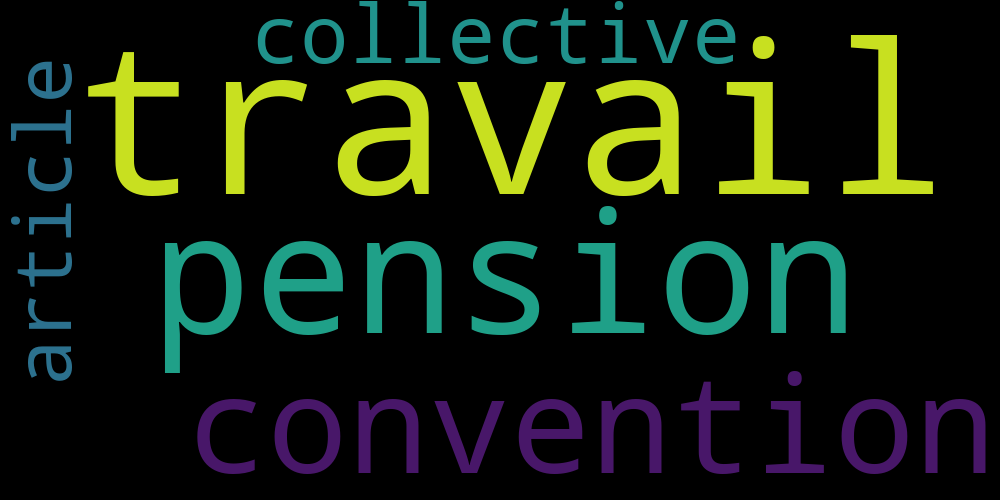

In [32]:
wordcloud.to_image()

In [33]:
# adding most frequent words as stop words
[preprocess.stop_words.add(w) for w in list(f_rel.keys())]
[w for w in list(preprocess.stop_words) if w in list(f_rel.keys())]

['collective', 'convention', 'travail', 'pension', 'article']

In [34]:
[w for w in list(preprocess.stop_words) if w in list(f_rel.keys())]

['collective', 'convention', 'travail', 'pension', 'article']

In [35]:
themes_keywords = pd.DataFrame(columns=['themeFr', 'frequency_absolute', 'frequency_relative'])
for t in themes_fr:
  mask = responses2.dropna(axis=0, subset=['themesFr']).themesFr.map(lambda x: t in x)
  r_t = responses2.dropna(axis=0, subset=['themesFr'])[mask]
  t_ts = preprocess.tokenize_texts(r_t["bodies_cleaned"])
  t_texts, t_f_abs, t_f_rel, t_wordcloud = filter_words(t_ts, freq_min=0.05, freq_max=0.95)
  themes_keywords = themes_keywords.append({'themeFr':t, 'frequency_absolute':t_f_abs, 'frequency_relative':t_f_rel}, ignore_index=True)
  print(f'Kewyords for {t} added, {len(r_t)} documents found')

Kewyords for PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES added, 36 documents found
Kewyords for PRIME SYNDICALE added, 20 documents found
Kewyords for TRAVAIL EN ÉQUIPE ET DE NUIT added, 63 documents found
Kewyords for PÉCULE DE VACANCES added, 6 documents found
Kewyords for PRIME PROPRE AU SECTEUR OU À L'ENTREPRISE added, 20 documents found
Kewyords for REMBOURSEMENT DE FRAIS (HORS FRAIS DE DÉPLACEMENT) added, 23 documents found
Kewyords for DÉTACHEMENT added, 18 documents found
Kewyords for PRIME DE FIN D'ANNÉE added, 37 documents found
Kewyords for SALAIRES added, 131 documents found
Kewyords for JEUNES TRAVAILLEURS: SALAIRES added, 47 documents found
Kewyords for FORMATION (EXCL. FORMATION SYNDICALE) added, 66 documents found
Kewyords for TRAVAILLEURS AGÉS-EXCL.PENSIONS COMPL, PRÉPENSION(RCC), CRÉDIT-TEMPS added, 101 documents found
Kewyords for MALADIE/ACCIDENT/DÉCÈS added, 28 documents found
Kewyords for CHÔMAGE (AUTRE QUE LE CHÔMAGE ÉCONOMIQUE DES EMPLOYÉS) added, 51 documents

In [36]:
for t in themes_fr:
  mask = responses2.dropna(axis=0, subset=['themesFr']).themesFr.map(lambda x: t in x)
  r_t = responses2.dropna(axis=0, subset=['themesFr'])[mask]
  print(f'{len(r_t)} contained for {t}')

36 contained for PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES
20 contained for PRIME SYNDICALE
63 contained for TRAVAIL EN ÉQUIPE ET DE NUIT
6 contained for PÉCULE DE VACANCES
20 contained for PRIME PROPRE AU SECTEUR OU À L'ENTREPRISE
23 contained for REMBOURSEMENT DE FRAIS (HORS FRAIS DE DÉPLACEMENT)
18 contained for DÉTACHEMENT
37 contained for PRIME DE FIN D'ANNÉE
131 contained for SALAIRES
47 contained for JEUNES TRAVAILLEURS: SALAIRES
66 contained for FORMATION (EXCL. FORMATION SYNDICALE)
101 contained for TRAVAILLEURS AGÉS-EXCL.PENSIONS COMPL, PRÉPENSION(RCC), CRÉDIT-TEMPS
28 contained for MALADIE/ACCIDENT/DÉCÈS
51 contained for CHÔMAGE (AUTRE QUE LE CHÔMAGE ÉCONOMIQUE DES EMPLOYÉS)
114 contained for RÉGIME DE CHÔMAGE AVEC COMPLÉMENT D'ENTREPRISE (RCC)
16 contained for FORMATION SYNDICALE
66 contained for FONDS DE SÉCURITÉ D'EXISTENCE
57 contained for INDEMNITÉS POUR FRAIS DE DÉPLACEMENT
57 contained for CRÉDIT-TEMPS/DIMINUTION DE CARRIÈRE, EMPLOI FIN DE CARRIÈRE
16 contained fo

In [37]:
themes_keywords.to_csv('/content/drive/My Drive/Becode/Kpmg/labeling.csv')

In [38]:
themes_keywords.loc[:, ['themeFr','frequency_relative']]

,themeFr,frequency_relative
0,PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES,"{'règlement': 1.0, 'régime': 0.9255464480874317, 'solidarité': 0.7650273224043715, 'sectoriel': 0.7452185792349727, 'van': 0.6038251366120219, 'complémentaire': 0.5348360655737705, 'partir': 0.47062841530054644, 'ofp': 0.4603825136612022, 'métal': 0.4..."
1,PRIME SYNDICALE,"{'cotisation': 1.0, 'partir': 0.9342560553633218, 'travailleurs': 0.8062283737024222, 'entreprises': 0.6678200692041523, 'janvier': 0.6505190311418685, 'ouvriers': 0.6193771626297578, 'sécurité': 0.5986159169550173, 'formation': 0.5743944636678201, 'p..."
2,TRAVAIL EN ÉQUIPE ET DE NUIT,"{'ouvriers': 1.0, 'prime': 0.9102803738317757, 'minimum': 0.8336448598130841, 'salaires': 0.8299065420560747, 'mois': 0.8018691588785046, 'présente': 0.719626168224299, 'paritaire': 0.7046728971962617, 'commission': 0.6654205607476635, 'chapitre': 0.5..."
3,PÉCULE DE VACANCES,"{'art': 1.0, 'mois': 0.9375, 'juillet': 0.84375, 'chômage': 0.71875, 'vacances': 0.71875, 'travaux': 0.6875, 'paritaire': 0.59375, 'entreprises': 0.59375, 'commission': 0.5625, 'durée': 0.5625, 'sectoriels': 0.5625, 'pécule': 0.5625, 'période': 0.5312..."
4,PRIME PROPRE AU SECTEUR OU À L'ENTREPRISE,"{'art': 1.0, 'salaires': 0.7081081081081081, 'minimum': 0.6432432432432432, 'salaire': 0.572972972972973, 'mois': 0.5351351351351351, 'chapitre': 0.5297297297297298, 'présente': 0.4486486486486487, 'heures': 0.4486486486486487, 'paritaire': 0.43783783..."
5,REMBOURSEMENT DE FRAIS (HORS FRAIS DE DÉPLACEMENT),"{'art': 1.0, 'prime': 0.9, 'entreprises': 0.8, 'partir': 0.7666666666666667, 'ouvriers': 0.7333333333333333, 'service': 0.7066666666666667, 'chauffeur': 0.6866666666666666, 'paritaire': 0.68, 'jours': 0.6733333333333333, 'mois': 0.62, 'chapitre': 0.61..."
6,DÉTACHEMENT,"{'fonds': 1.0, 'janvier': 0.6819571865443425, 'paritaire': 0.6085626911314985, 'ouvriers': 0.599388379204893, 'travailleurs': 0.5902140672782875, 'commission': 0.5749235474006116, 'sécurité': 0.5626911314984709, 'van': 0.5596330275229358, 'durée': 0.5..."
7,PRIME DE FIN D'ANNÉE,"{'fin': 1.0, 'cct': 0.9055944055944056, 'présente': 0.7622377622377622, 'commission': 0.7447552447552448, 'paritaire': 0.7272727272727273, 'travailleurs': 0.6853146853146853, 'chômage': 0.6398601398601399, 'mois': 0.6293706293706294, 'jours': 0.625874..."
8,SALAIRES,"{'van': 1.0, 'ouvriers': 0.9033333333333333, 'paritaire': 0.8344444444444444, 'salaires': 0.82, 'travailleurs': 0.8133333333333334, 'minimum': 0.7855555555555556, 'commission': 0.7666666666666667, 'partir': 0.7644444444444445, 'présente': 0.7166666666..."
9,JEUNES TRAVAILLEURS: SALAIRES,"{'minimum': 1.0, 'salaires': 0.986870897155361, 'ouvriers': 0.949671772428884, 'chapitre': 0.687089715536105, 'mois': 0.6214442013129103, 'juillet': 0.6017505470459519, 'ler': 0.6017505470459519, 'euro': 0.5317286652078774, 'heures': 0.525164113785557..."


# Classification model

In [39]:
from pickle import load

with open(os.path.join(KPMG_PATH, "clas_new.pkl"), 'rb') as f:
  df = load(f)

In [40]:
df.columns

Index(['depositNumber', 'displayJcId', 'titleFr', 'themesFr',
       'publicationDate', 'scopeFr', 'endDate', 'enforced', 'docBodyFr'],
      dtype='object')

In [41]:
df["body_cleaned"] = df["docBodyFr"].apply(preprocess.clean_text)

In [42]:
#generating all possible FR themes (replacing previous list of 53 items)
themes_fr = []
for r in  df.themesFr:
    if r is not None:
        for t in r:
            if t not in themes_fr:
                themes_fr += [t]
len(themes_fr)

54

In [43]:
# showing only 27 unique themes against 54 available
df.dropna(axis=0, subset=['themesFr'], inplace=True)
df['theme'] = df['themesFr'].apply(lambda x: x[0] if len(x) == 1 else None)
len(df.theme.unique())

27

In [44]:
for t in themes_fr:
	df.dropna(axis=0, subset=['themesFr'], inplace=True)
	df[t] = df['themesFr'].apply(lambda x: 1 if t in x else 0)
df.columns

Index(['depositNumber', 'displayJcId', 'titleFr', 'themesFr',
       'publicationDate', 'scopeFr', 'endDate', 'enforced', 'docBodyFr',
       'body_cleaned', 'theme',
       'PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES', 'PRIME SYNDICALE',
       'TRAVAIL EN ÉQUIPE ET DE NUIT', 'PÉCULE DE VACANCES',
       'PRIME PROPRE AU SECTEUR OU À L'ENTREPRISE',
       'REMBOURSEMENT DE FRAIS (HORS FRAIS DE DÉPLACEMENT)', 'DÉTACHEMENT',
       'PRIME DE FIN D'ANNÉE', 'SALAIRES', 'JEUNES TRAVAILLEURS: SALAIRES',
       'FORMATION (EXCL. FORMATION SYNDICALE)',
       'TRAVAILLEURS AGÉS-EXCL.PENSIONS COMPL, PRÉPENSION(RCC), CRÉDIT-TEMPS',
       'MALADIE/ACCIDENT/DÉCÈS',
       'CHÔMAGE (AUTRE QUE LE CHÔMAGE ÉCONOMIQUE DES EMPLOYÉS)',
       'RÉGIME DE CHÔMAGE AVEC COMPLÉMENT D'ENTREPRISE (RCC)',
       'FORMATION SYNDICALE', 'FONDS DE SÉCURITÉ D'EXISTENCE',
       'INDEMNITÉS POUR FRAIS DE DÉPLACEMENT',
       'CRÉDIT-TEMPS/DIMINUTION DE CARRIÈRE, EMPLOI FIN DE CARRIÈRE',
       'RECRUTEMENT', 'GR